In [4]:
from sqlalchemy import text
from database.connection import session_local
import pandas as pd
import matplotlib.pyplot as plt

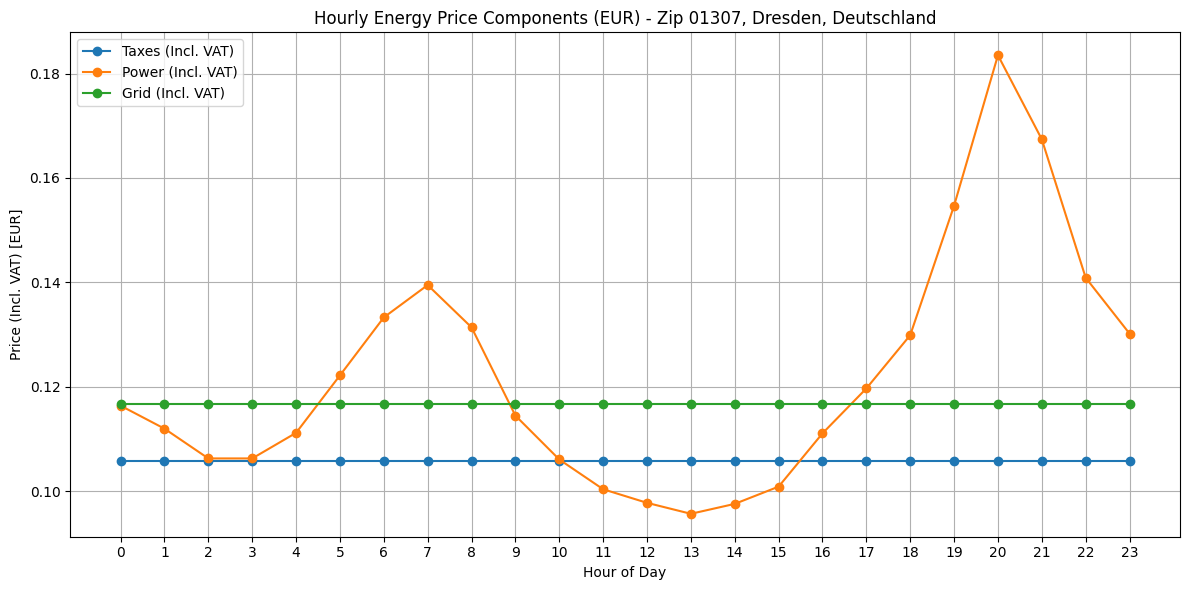

In [5]:
sql = text("""
SELECT
  pa_data ->> 'currency' AS "Currency",
  elem ->> 'date' AS "Date", 
  elem ->> 'hour' AS "Hour", 

  -- Taxes
  (SELECT (pc ->> 'priceExcludingVat')::numeric 
   FROM jsonb_array_elements(elem -> 'priceComponents') AS pc
   WHERE pc ->> 'type' = 'taxes' LIMIT 1) AS "taxes_ex_vat",

  (SELECT (pc ->> 'priceIncludingVat')::numeric 
   FROM jsonb_array_elements(elem -> 'priceComponents') AS pc
   WHERE pc ->> 'type' = 'taxes' LIMIT 1) AS "taxes_in_vat",

  -- Power
  (SELECT (pc ->> 'priceExcludingVat')::numeric 
   FROM jsonb_array_elements(elem -> 'priceComponents') AS pc
   WHERE pc ->> 'type' = 'power' LIMIT 1) AS "power_ex_vat",

  (SELECT (pc ->> 'priceIncludingVat')::numeric 
   FROM jsonb_array_elements(elem -> 'priceComponents') AS pc
   WHERE pc ->> 'type' = 'power' LIMIT 1) AS "power_in_vat",

  -- Grid
  (SELECT (pc ->> 'priceExcludingVat')::numeric 
   FROM jsonb_array_elements(elem -> 'priceComponents') AS pc
   WHERE pc ->> 'type' = 'grid' LIMIT 1) AS "grid_ex_vat",

  (SELECT (pc ->> 'priceIncludingVat')::numeric 
   FROM jsonb_array_elements(elem -> 'priceComponents') AS pc
   WHERE pc ->> 'type' = 'grid' LIMIT 1) AS "grid_in_vat",

  pa_code AS "Zip Code", 
  ci_name AS "City", 
  c_name AS "Country"

FROM t_postal_area 
JOIN t_city     ON t_city.ci_id = t_postal_area.ci_id 
JOIN t_province ON t_province.p_id = t_city.p_id
JOIN t_country  ON t_country.c_id = t_province.c_id,
LATERAL jsonb_array_elements(pa_data -> 'energy' -> 'todayHours') AS elem

WHERE pa_code = '01307';
""")

with session_local() as session:
    result = session.execute(sql)
    df = pd.DataFrame(result.fetchall(), columns=result.keys())

df.columns = [col.lower().replace(" ", "_") for col in df.columns]
df['hour'] = df['hour'].astype(int)
df = df.sort_values(by='hour')

currency = df['currency'].iloc[0]

plt.figure(figsize=(12, 6))
plt.plot(df['hour'], df['taxes_in_vat'], label='Taxes (Incl. VAT)', marker='o')
plt.plot(df['hour'], df['power_in_vat'], label='Power (Incl. VAT)', marker='o')
plt.plot(df['hour'], df['grid_in_vat'], label='Grid (Incl. VAT)', marker='o')

plt.title(f"Hourly Energy Price Components ({currency}) - Zip {df['zip_code'].iloc[0]}, {df['city'].iloc[0]}, {df['country'].iloc[0]}")
plt.xlabel('Hour of Day')
plt.ylabel(f'Price (Incl. VAT) [{currency}]')
plt.grid(True)
plt.legend()
plt.xticks(df['hour'])
plt.tight_layout()
plt.show()

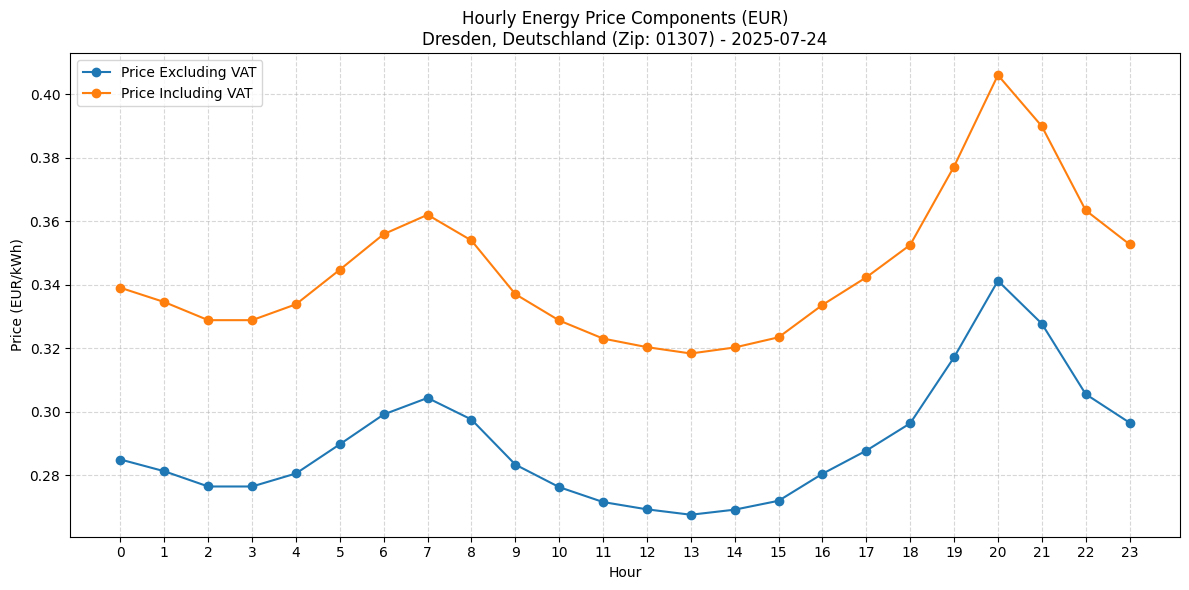

In [6]:
sql = text("""
SELECT
  pa_data ->> 'currency' AS "Currency",
  elem ->> 'date' AS "Date", 
  elem ->> 'hour' AS "Hour", 

  (elem ->> 'priceExcludingVat')::numeric AS "Price_Exc_Vat",
  (elem ->> 'priceIncludingVat')::numeric AS "Price_Inc_Vat",
  ((elem ->> 'priceIncludingVat')::numeric - (elem ->> 'priceExcludingVat')::numeric) AS "VAT",

  pa_code AS "Zip Code", 
  ci_name AS "City", 
  c_name AS "Country"

FROM t_postal_area 
JOIN t_city     ON t_city.ci_id = t_postal_area.ci_id 
JOIN t_province ON t_province.p_id = t_city.p_id
JOIN t_country  ON t_country.c_id = t_province.c_id
CROSS JOIN LATERAL jsonb_array_elements(pa_data -> 'energy' -> 'todayHours') AS elem

WHERE pa_code = '01307'
""")

with session_local() as session:
    result = session.execute(sql)
    df = pd.DataFrame(result.fetchall(), columns=result.keys())

df['Hour'] = pd.to_numeric(df['Hour'], errors='coerce')
df = df.dropna(subset=['Hour'])
df['Hour'] = df['Hour'].astype(int)
df = df.sort_values('Hour')

currency = df['Currency'].iloc[0]
zip_code = df['Zip Code'].iloc[0]
city = df['City'].iloc[0]
country = df['Country'].iloc[0]
date = df['Date'].iloc[0]

plt.figure(figsize=(12, 6))
plt.plot(df['Hour'], df['Price_Exc_Vat'], label='Price Excluding VAT', marker='o')
plt.plot(df['Hour'], df['Price_Inc_Vat'], label='Price Including VAT', marker='o')

plt.title(f"Hourly Energy Price Components ({currency})\n{city}, {country} (Zip: {zip_code}) - {date}")
plt.xlabel("Hour")
plt.ylabel(f"Price ({currency}/kWh)")
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()